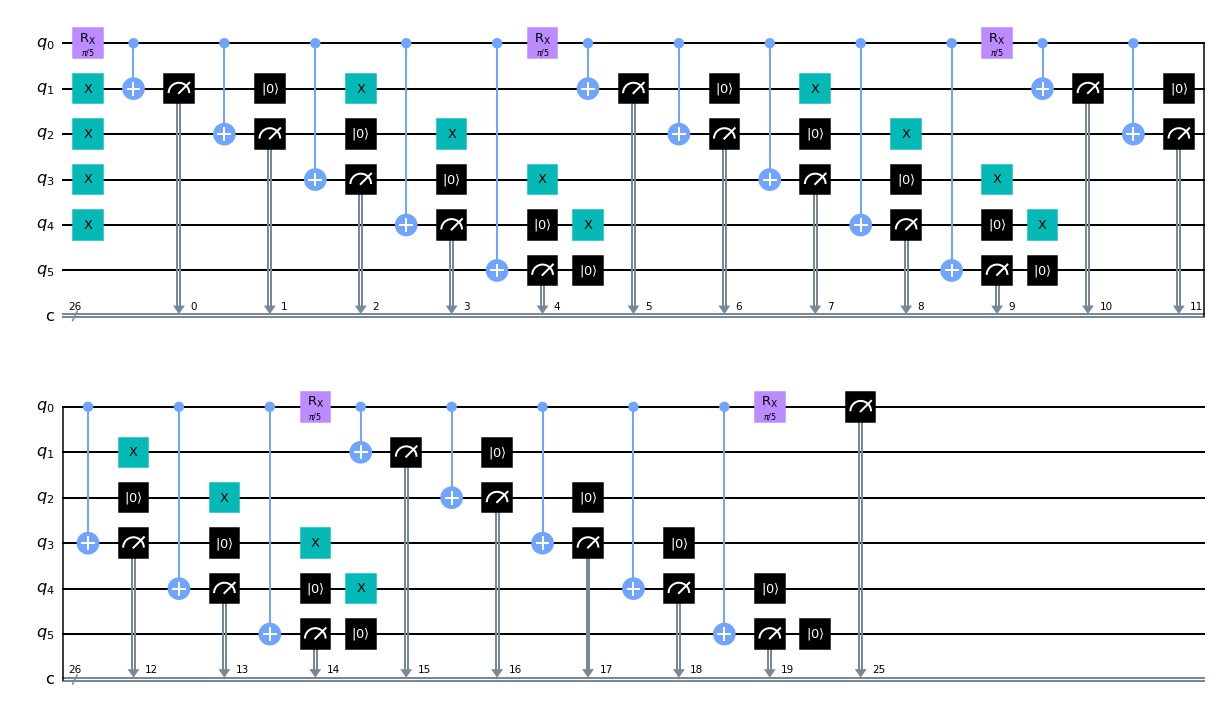

In [53]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate
from random import randint
import numpy as np

cycles = 5 # how many times we repeat the search process (more means more runtime but higher probability of not eating cheese when getting correct answer)
theta = np.pi/cycles # how much we're rotating the beam splitter each measure

# randomly decide where to place the cheese
cheese_index = randint(1,5)

def q_cheese_finder(cycles) -> QuantumCircuit:
     # 1 for each possible placement of the cheese and 1 quantum mouse searching
    qr = QuantumRegister(6, 'q')
    cr = ClassicalRegister(cycles*5+1, 'c')
    qc = QuantumCircuit(qr, cr)
    for cycle in range(cycles-1):
        qc.append(RXGate(theta), [qr[0]])
        for cheese in range(1,6):
            if (cheese!=cheese_index):
                qc.x(cheese) # If there is no cheese for this path we apply a not gate
            qc.cx(qr[0], qr[cheese]) # quantum mouse using a cnot gate as means of "checking" for cheese
            qc.measure(qr[cheese],cr[cycle*5+cheese-1])
            if cycle < cycles-1:
                qc.reset(qr[cheese])
        
    qc.append(RXGate(theta), [qr[0]]) # final gate check
    qc.measure(qr[0],cr[cycles*5])
    return qc

successes = 0 # We will use this variable to track the number of successful predictions in a row

zeno_circuit = q_cheese_finder(cycles)
zeno_circuit.draw(output='mpl')

In [54]:
from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

qsweeper_job = simulator.run(zeno_circuit, shots=1000)
qsweeper_result = qsweeper_job.result()
qsweeper_counts = qsweeper_result.get_counts(zeno_circuit)
print(qsweeper_counts)

# the indices we're going to check for a "correct" measurement, where the mouse finds the cheese and does not eat it
check_indices = []
max_index = cycles*5+1
for cycle in range(cycles-1):
    # registers read back to front the way qiskit is set up
    index = max_index-(cheese_index*(cycle*1+1))
    check_indices.append(index)
check_indices.append(0)


correct_count = 0
for possibility in qsweeper_counts:
    correct = True
    for index in check_indices:
        if (possibility[index]!='0'):
            correct = False
    
    if (correct==True):
        correct_count = qsweeper_counts[possibility]

print("Our mouse was correct while not eating the cheese " + str(correct_count/10) + "% of the time!")

{'00000001111011110111101111': 614, '00000001111011111000001111': 4, '10000001111011110111101111': 79, '10000010000100000111101111': 59, '10000010000100001000001111': 60, '00000001111100001000001111': 5, '10000010000011110111101111': 53, '10000010000100001000010000': 80, '00000010000100001000010000': 6, '00000010000100000111101111': 3, '00000010000011110111101111': 4, '00000001111100000111101111': 5, '00000001111011110111110000': 6, '10000001111100000111101111': 3, '10000010000011111000001111': 2, '00000001111011111000010000': 4, '10000010000011110111110000': 1, '10000010000100000111110000': 1, '00000001111100001000010000': 4, '00000010000100001000001111': 5, '10000001111011110111110000': 2}
Our mouse was correct while not eating the cheese 61.4% of the time!
